<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/8_basic_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires export_clean.csv (cleaned up export CSV with sorts and time columns)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/dataset.csv')

In [13]:
df.columns

Index(['NDVI', 'NDBI', 'NDMI', 'Albedo', 'time_years', 'long', 'lat',
       'distance', 'hour_of_day', 'month', 'm'],
      dtype='object')

In [14]:
train_columns = ['NDVI', 'NDBI', 'NDMI', 'Albedo', 'time_years', 'distance', 'hour_of_day', 'month', 'm']
train_df = df[train_columns]

In [15]:
train_df

,NDVI,NDBI,NDMI,Albedo,time_years,distance,hour_of_day,month,m
0,0.008107,-0.042450,0.042450,0.185196,18.979367,317.553292,1,12,-0.029627
1,0.008107,-0.105622,0.105622,0.183640,18.979367,317.478476,1,12,-0.003934
2,-0.011292,-0.099890,0.099890,0.176036,18.979367,287.478569,1,12,-0.007349
3,-0.029073,-0.068238,0.068238,0.171996,18.979367,287.403753,1,12,-0.007378
4,0.008107,-0.092413,0.092413,0.181680,18.979367,257.403847,1,12,-0.019299
...,...,...,...,...,...,...,...,...,...
2646549,0.192808,0.070690,-0.070690,0.085628,56.083537,285.926939,2,1,-0.037815
2646550,0.306176,0.073418,-0.073418,0.127741,56.083537,294.332867,2,1,-0.026298
2646551,0.157747,-0.135409,0.135409,0.149991,56.083537,305.465969,2,1,-0.020183
2646552,0.157339,0.031072,-0.031072,0.071202,56.083537,315.186207,2,1,-0.031023


In [ ]:
train_df.boxplot(column=['Albedo'])

# Prep ML

In [16]:
TARGET = 'm'
FEATURES = [c for c in df.columns if c != TARGET]

X = df[FEATURES].values.astype(np.float32)
y = df[TARGET].values.astype(np.float32).reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [18]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
BATCH_SIZE = 8192  # tune based on GPU/CPU memory

train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
EPOCHS = 10  # increase if needed

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    preds_list = []
    y_list = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item() * xb.size(0)

            preds_list.append(preds.cpu().numpy())
            y_list.append(yb.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    y_val_pred = np.vstack(preds_list)
    y_val_true = np.vstack(y_list)

    r2 = r2_score(y_val_true, y_val_pred)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train MSE: {train_loss:.4f} | "
          f"Val MSE: {val_loss:.4f} | "
          f"R2: {r2:.4f}")

Epoch 1/10 | Train MSE: 0.0080 | Val MSE: 0.0021 | R2: 0.0644
Epoch 2/10 | Train MSE: 0.0021 | Val MSE: 0.0018 | R2: 0.2028
Epoch 3/10 | Train MSE: 0.0018 | Val MSE: 0.0022 | R2: 0.0352
Epoch 4/10 | Train MSE: 0.0015 | Val MSE: 0.0016 | R2: 0.3134
Epoch 5/10 | Train MSE: 0.0014 | Val MSE: 0.0013 | R2: 0.4250
Epoch 6/10 | Train MSE: 0.0013 | Val MSE: 0.0012 | R2: 0.4622
Epoch 7/10 | Train MSE: 0.0012 | Val MSE: 0.0012 | R2: 0.4841
Epoch 8/10 | Train MSE: 0.0012 | Val MSE: 0.0013 | R2: 0.4475
Epoch 9/10 | Train MSE: 0.0012 | Val MSE: 0.0010 | R2: 0.5538
Epoch 10/10 | Train MSE: 0.0010 | Val MSE: 0.0010 | R2: 0.5739


In [23]:
epoch, train_mse, val_mse, r2 = [], [], [], []

In [25]:
epoch.append(1); train_mse.append(0.0080); val_mse.append(0.0021); r2.append(0.0644)
epoch.append(2); train_mse.append(0.0021); val_mse.append(0.0018); r2.append(0.2028)
epoch.append(3); train_mse.append(0.0018); val_mse.append(0.0022); r2.append(0.0352)
epoch.append(4); train_mse.append(0.0015); val_mse.append(0.0016); r2.append(0.3134)
epoch.append(5); train_mse.append(0.0014); val_mse.append(0.0013); r2.append(0.4250)
epoch.append(6); train_mse.append(0.0013); val_mse.append(0.0012); r2.append(0.4622)
epoch.append(7); train_mse.append(0.0012); val_mse.append(0.0012); r2.append(0.4841)
epoch.append(8); train_mse.append(0.0012); val_mse.append(0.0013); r2.append(0.4475)
epoch.append(9); train_mse.append(0.0012); val_mse.append(0.0010); r2.append(0.5538)
epoch.append(10); train_mse.append(0.0010); val_mse.append(0.0010); r2.append(0.5739)

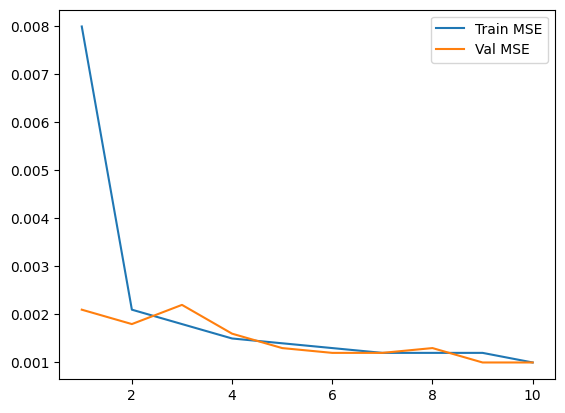

In [29]:
plt.plot(epoch, train_mse, label="Train MSE")
plt.plot(epoch, val_mse, label="Val MSE")

plt.legend()
plt.show()

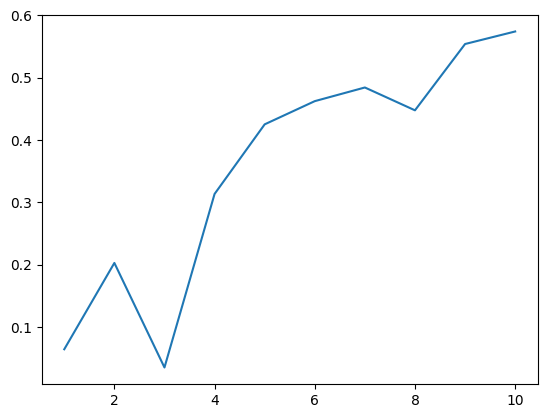

In [30]:
plt.plot(epoch, r2, label="R^2")
plt.show()

# Inverse modeling

In [31]:
FEATURES

['NDVI',
 'NDBI',
 'NDMI',
 'Albedo',
 'time_years',
 'long',
 'lat',
 'distance',
 'hour_of_day',
 'month']

In [32]:
feature_names = FEATURES
feature_to_idx = {name: i for i, name in enumerate(feature_names)}

In [38]:
def inverse_solve(
    model,
    scaler,
    y_target,
    n_solutions=10,
    steps=500,
    lr=0.001,
    tolerance=0.01,
    fixed_features=None,
    l2_reg=0.01,
    bounds=None
):
    """
    model: trained PyTorch model (already on device)
    scaler: fitted StandardScaler
    y_target: desired label (float)
    n_solutions: number of random restarts
    tolerance: keep solutions with |prediction - target| < tolerance
    fixed_features: dict {"NDVI": value, ...}
    bounds: dict {"NDVI": (min,max), ...}
    """

    model.eval()
    solutions = []

    y_target_tensor = torch.tensor([[y_target]], dtype=torch.float32).to(device)

    for _ in range(n_solutions):

        # random initialization in scaled space
        x = torch.randn((1, len(feature_names)), device=device, requires_grad=True)

        optimizer_x = torch.optim.Adam([x], lr=lr)

        for step in range(steps):

            optimizer_x.zero_grad()

            pred = model(x)
            loss = (pred - y_target_tensor).pow(2).mean()

            # L2 regularization (keeps solution near origin in scaled space)
            loss += l2_reg * torch.norm(x)

            # Soft constraint: fixed features
            if fixed_features:
                for fname, fval in fixed_features.items():
                    idx = feature_to_idx[fname]
                    scaled_val = (fval - scaler.mean_[idx]) / scaler.scale_[idx]
                    loss += 100 * (x[0, idx] - scaled_val) ** 2

            loss.backward()
            optimizer_x.step()

            # Hard bounds
            if bounds:
                with torch.no_grad():
                    for fname, (low, high) in bounds.items():
                        idx = feature_to_idx[fname]
                        low_s = (low - scaler.mean_[idx]) / scaler.scale_[idx]
                        high_s = (high - scaler.mean_[idx]) / scaler.scale_[idx]
                        x[0, idx].clamp_(low_s, high_s)

        # Check tolerance
        with torch.no_grad():
            pred = model(x)
            error = torch.abs(pred - y_target_tensor).item()

            if error < tolerance:
                x_np = x.cpu().numpy()
                x_orig = scaler.inverse_transform(x_np)
                solutions.append(x_orig.flatten())

    return np.array(solutions)

In [78]:
solutions_1 = inverse_solve(
    model=model,
    scaler=scaler,
    y_target=0.1,
    n_solutions=100,
    tolerance=0.1
)

print("Found solutions:", len(solutions_1))

Found solutions: 100


In [48]:
solutions_2 = inverse_solve(
    model,
    scaler,
    y_target=-0.03,
    n_solutions=100,
    tolerance=0.01,
    fixed_features={"NDVI": 0.3}
)

print("Found solutions:", len(solutions_2))

Found solutions: 0


In [49]:
bounds = {
    "NDVI": (0, 1),
    "NDMI": (-1, 1),
    "hour_of_day": (0, 23),
    "month": (1, 12)
}

solutions_3 = inverse_solve(
    model,
    scaler,
    y_target=-0.03,
    n_solutions=200,
    tolerance=0.02,
    bounds=bounds
)

In [50]:
len(solutions_3)

0

In [56]:
df_solutions = pd.DataFrame(solutions_1, columns=feature_names)
df_solutions.describe()

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.047244,-0.198664,0.322673,0.114781,46.718273,127.018021,37.570206,211.192184,1.067500,3.065200
std,1.048663,0.436466,0.486610,0.049406,7.731159,0.013555,0.001527,171.065903,0.937328,3.210405
min,-0.310570,-0.914157,-0.497046,0.072249,34.533051,126.999107,37.567760,-4.660467,-0.463833,-0.893876
25%,0.548232,-0.197297,0.374165,0.086413,45.765587,127.009590,37.570038,161.795074,1.118930,0.546973
50%,0.983552,-0.117079,0.386100,0.101974,47.689957,127.021118,37.570522,193.870132,1.276219,3.372518
75%,1.529038,-0.029648,0.574648,0.114908,50.086334,127.029091,37.570805,234.583466,1.306105,5.947385
max,2.485967,0.264861,0.775500,0.198364,55.516457,127.031212,37.571896,470.372681,2.100077,6.353000


In [57]:
df_solutions

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month
0,0.548232,-0.029648,-0.497046,0.101974,47.689957,127.009590,37.567760,-4.660467,1.306105,6.353000
1,1.529038,-0.914157,0.775500,0.086413,34.533051,127.029091,37.570038,470.372681,2.100077,0.546973
2,-0.310570,-0.197297,0.574648,0.198364,50.086334,127.031212,37.570805,161.795074,1.118930,-0.893876
3,0.983552,-0.117079,0.386100,0.114908,45.765587,127.021118,37.570522,234.583466,-0.463833,5.947385
4,2.485967,0.264861,0.374165,0.072249,55.516457,126.999107,37.571896,193.870132,1.276219,3.372518


In [74]:
single_input = solutions_1[4]

single_input_scaled = scaler.transform(single_input.reshape(1, -1))  # Shape it to 2D for scaler
single_input_tensor = torch.tensor(single_input_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_label = model(single_input_tensor).cpu().numpy()  # Convert the output to a NumPy array

print(f"Predicted label: {predicted_label}")


Predicted label: [[0.03285752]]


In [97]:
single_input

array([2.4859669e+00, 2.6486096e-01, 3.7416539e-01, 7.2248593e-02,
       5.5516457e+01, 1.2699911e+02, 3.7571896e+01, 1.9387013e+02,
       1.2762189e+00, 3.3725176e+00], dtype=float32)

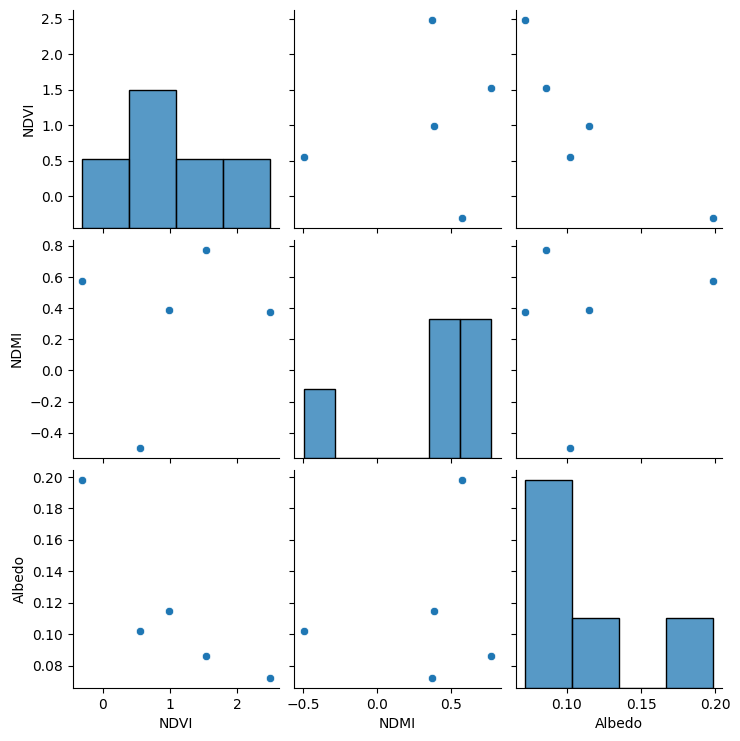

In [70]:
import seaborn as sns

sns.pairplot(df_solutions[["NDVI","NDMI","Albedo"]])

# Shap Analysis

In [79]:
# Sample for SHAP (adjust sizes if needed)
BACKGROUND_SIZE = 200
EXPLAIN_SIZE = 500

background_idx = np.random.choice(len(X_train), BACKGROUND_SIZE, replace=False)
explain_idx = np.random.choice(len(X_val), EXPLAIN_SIZE, replace=False)

X_background = torch.from_numpy(X_train[background_idx]).to(device)
X_explain = torch.from_numpy(X_val[explain_idx]).to(device)

In [80]:
model.eval()

explainer = shap.DeepExplainer(model, X_background)
shap_values = explainer.shap_values(X_explain)

In [81]:
shap_values.shape

(500, 10, 1)

In [82]:
shap_values[0]

array([[-1.97117421e-04],
       [ 8.53447727e-06],
       [ 5.29622012e-05],
       [-9.87795414e-04],
       [-1.59431454e-02],
       [ 2.23160442e-03],
       [-2.23814306e-04],
       [-1.79877058e-02],
       [ 2.83390749e-03],
       [-8.51181429e-03]])

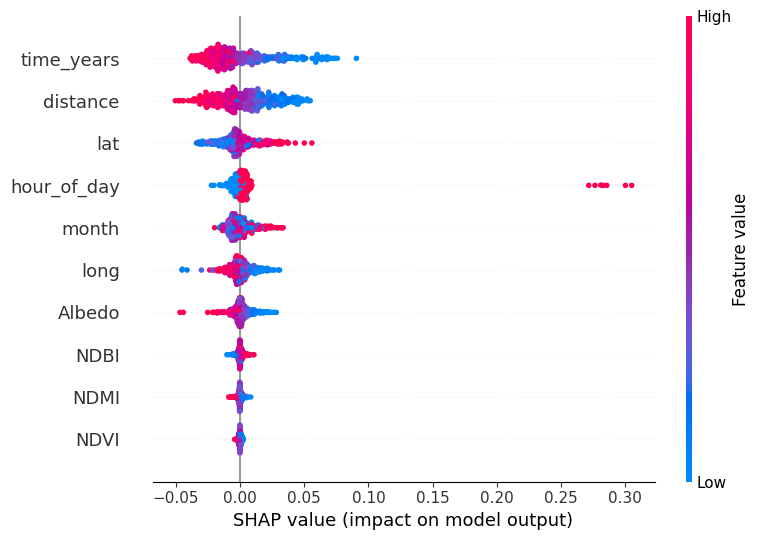

In [83]:
# Remove the last dimension
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_vals = np.squeeze(shap_vals)  # shape: (5000, 10)

# Now plot
shap.summary_plot(
    shap_vals,
    X_val[explain_idx],
    feature_names=FEATURES,
    show=True
)

In [84]:
print("SHAP values shape:", shap_vals.shape)  # should be (500, 10)

SHAP values shape: (500, 10)


## Save the model

In [85]:
PATH = "/content/sample_data/MLP.pt"
torch.save(model.state_dict(), PATH)

In [108]:
test_input = np.array([0.008107, -0.042450, 0.042450, 0.185196, 18.979367, 317.553292, 1, 12, -0.029627, 3.3725176e+00])

# single_input_scaled = scaler.transform(test_input.reshape(1, -1))  # Shape it to 2D for scaler
single_input_scaled = test_input.reshape(1, -1)  # Shape it to 2D for scaler
# single_input_scaled = scaler.transform(test_input.reshape(1, -1))  # Shape it to 2D for scaler
single_input_tensor = torch.tensor(single_input_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predicted_label = model(single_input_tensor).cpu().numpy()  # Convert the output to a NumPy array

print(f"Predicted label: {predicted_label}")

Predicted label: [[5.6785226]]
